In [1]:
import logging
import sys

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

In [10]:
import sys
from scripts.path_findings import ch_builder

import numpy as np

sys.path.append('../scripts')
sys.path.append('../')

from scripts import graph_osm_loader
from scripts import pipeline, centroids_graph_builder, clustering
from scripts.path_findings import excraction_pfa, dijkstra_pfa
from scripts import utils

In [3]:
    # 'PARIS': 'R71525',
# 'Prague': 'R435514',
# 
# 'DUBAI': 'R3766483',


In [6]:
GRAPH_ID = 'R13470549'  # R13470549 R2555133 R3766483
# примеры id есть в graph_osm_loader.py
g = graph_osm_loader.get_graph(GRAPH_ID)
print(len(g.nodes), len(g.edges))

723 1046


In [5]:
GRAPH_ID = 'R435514'  # R13470549 R2555133 R3766483
# примеры id есть в graph_osm_loader.py
g = graph_osm_loader.get_graph(GRAPH_ID)
print(len(g.nodes), len(g.edges))

21702 30009


In [24]:
GRAPH_ID = 'R2555133'  # R13470549 R2555133 R3766483
# примеры id есть в graph_osm_loader.py
g = graph_osm_loader.get_graph(GRAPH_ID)
print(len(g.nodes), len(g.edges))

17970 27107


In [25]:
points = utils.read_points(GRAPH_ID, g, num=1000)

In [8]:
nodes = g.nodes()

In [30]:


def dst(da, db):
    return ((da['x'] - db['x']) ** 2 + (da['y'] - db['y']) ** 2) ** 0.5 / 360 * 2 * np.pi * 6371.01 * 1000 * 0.56


def node_dst(u, v):
    da = nodes[u]
    db = nodes[v]
    return dst(da, db)

In [31]:
from pympler.asizeof import asizeof

In [32]:

cms_resolver = clustering.LouvainCommunityResolver(resolution=100)

t, cg = centroids_graph_builder.CentroidGraphBuilder().build_with_time(g, cms_resolver)
t, asizeof(cg) / 1024 / 1024, asizeof(g) / 1024 / 1024

find centroids:   0%|          | 0/1661 [00:00<?, ?it/s]

find edges:   0%|          | 0/1661 [00:00<?, ?it/s]

(9.942084550857544, 6.217681884765625, 19.52996826171875)

In [33]:
len(cg.cms) ** 2 * 8 / 1024 / 1024

21.04889678955078

In [34]:

chpfa = ch_builder.GreedyChBuilder().build_ch_pfa(cg.g)


build ch graph:   0%|          | 0/1661 [00:00<?, ?it/s]

In [35]:


baseline = dijkstra_pfa.Dijkstra(g)
# 
test_alg = excraction_pfa.ExtractionPfa(
    g=g,
    upper=chpfa,
    down=dijkstra_pfa.Dijkstra(g)
)

# test_alg = ArcFlagsBuilder().build(g, cg.cls2hubs)
# test_alg = dijkstra_pfa.AStar(
#     g = g,
#     h = node_dst
# )
# test_alg = ClusterAltBuilder(0.1).build_ch_pfa(g)

In [36]:
len(cg.cms)

1661

In [37]:
# test_alg = MinClusterDistance(workers=10).build_astar(g, cg.cms)

In [38]:
stat = pipeline.PfaComparator(
    baseline=baseline,
    test_algorithm=test_alg,
    points=points,
    workers=4
).compare()

start 0


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

start 1


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

start 2


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

start 3


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

In [39]:
stat


        err_max:    191.0248
        err_min:    0.0000
        err_median: 11.4312
        err_mean:   13.7027
        
        acceleration_max:    67.0140
        acceleration_min:    0.4381
        acceleration_median: 16.7148
        acceleration_mean:   17.3691
        

In [28]:
from tqdm.auto import tqdm

points = utils.read_points(GRAPH_ID, g, num=1000)
resolutions = [10, 30, 50, 70, 90, 100, 200, 500, 1000]
alphas = []
stats = []
baseline = dijkstra_pfa.Dijkstra(g)
for r in tqdm(resolutions):
    cms_resolver = clustering.LouvainCommunityResolver(resolution=r)
    cg = centroids_graph_builder.CentroidGraphBuilder(log=False).build(g, cms_resolver)

    alpha = len(cg.cms) / len(g.nodes())
    alphas.append(alpha)
    tqdm.write(f'alpha = {alpha:.2f}')

    chpfa = ch_builder.GreedyChBuilder(print_log=False).build_ch_pfa(cg.g)
    test_alg = excraction_pfa.ExtractionPfa(
        g=g,
        upper=chpfa,
        down=dijkstra_pfa.Dijkstra(g)
    )

    stat = pipeline.PfaComparator(
        baseline=baseline,
        test_algorithm=test_alg,
        points=points,
        workers=4,
        print_log=False
    ).compare()

    stats.append(stat)

  0%|          | 0/9 [00:00<?, ?it/s]

alpha = 0.03
alpha = 0.05
alpha = 0.07
alpha = 0.08
alpha = 0.09
alpha = 0.09
alpha = 0.13
alpha = 0.19
alpha = 0.26


Text(0.5, 0, 'alpha')

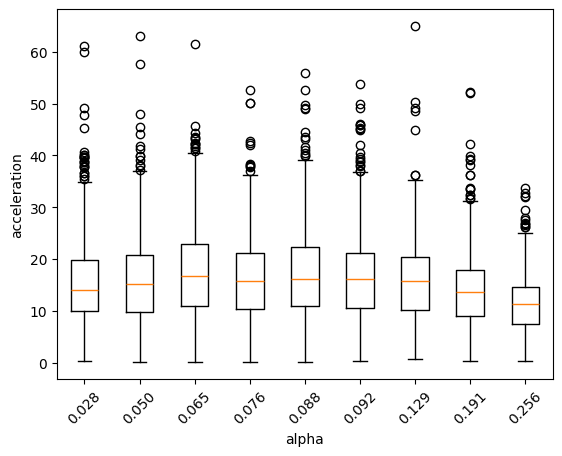

In [30]:
from matplotlib import pyplot as plt

plt.boxplot([stat.get_acceleration() for stat in stats])
plt.xticks(list(range(1, len(alphas) + 1)), [f'{a:.3f}' for a in alphas], rotation=45)
plt.ylabel('acceleration')
plt.xlabel('alpha')